https://github.com/rasbt/stat453-deep-learning-ss21/blob/main/L16/helper_train.py

In [3]:
import torch
import torch.nn as nn
from torch.optim import SGD
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

import torch.distributions as TD
from zmq import device
import torch.optim as optim
from datetime import datetime
import functools
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import torch.nn as nn

# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

import torch.nn as nn


class CTDataset(Dataset):
    def __init__(self, filepath):
        self.x, self.y = torch.load(filepath)
        self.x = self.x / 255.
        self.y = F.one_hot(self.y, num_classes=10).to(float)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]

def plot_training_loss(minibatch_losses, num_epochs, averaging_iterations=100, custom_label=''):

    minibatch_losses = np.log(minibatch_losses)
    iter_per_epoch = len(minibatch_losses) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_losses)),
             (minibatch_losses), label=f'Minibatch Loss{custom_label}')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Log Loss')

    if len(minibatch_losses) < 1000:
        num_losses = len(minibatch_losses) // 2
    else:
        num_losses = 1000

    # ax1.set_ylim([ 0, np.max(minibatch_losses[num_losses:])*1.5 ])

    ax1.plot(np.convolve(minibatch_losses,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label=f'Running Average{custom_label}')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::100])
    ax2.set_xticklabels(newlabel[::100])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()


def plot_accuracy(train_acc, valid_acc):

    num_epochs = len(train_acc)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             valid_acc, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()


def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images, sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):

        features = features.to(device)
        features = features.reshape(-1, 1, 28, 28)
        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            if modeltype == 'autoencoder':
                with torch.no_grad():
                    decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

##########################
### MODEL
##########################


class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class Trim(nn.Module):
    def __init__(self, *args):
        super().__init__()

    def forward(self, x):
        return x[:, :, :28, :28]


class AutoEncoder(nn.Module):
    def __init__(self, d_l):
        super().__init__()

        self.encoder = nn.Sequential( #784
                nn.Conv2d(1, 32, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(32, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1),
                nn.LeakyReLU(0.01),
                nn.Conv2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1),
                nn.Flatten(),
                nn.Linear(3136, d_l)
        )
        self.decoder = nn.Sequential(
                torch.nn.Linear(d_l, 3136),
                Reshape(-1, 64, 7, 7),
                nn.ConvTranspose2d(64, 64, stride=(1, 1), kernel_size=(3, 3), padding=1), # 64x7x7 -> 64x7x7
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 64, stride=(2, 2), kernel_size=(3, 3), padding=1), # 64x7x7 -> 64x13x13
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(64, 32, stride=(2, 2), kernel_size=(3, 3), padding=0), # 64x13x13 -> 32x27x27
                nn.LeakyReLU(0.01),
                nn.ConvTranspose2d(32, 1, stride=(1, 1), kernel_size=(3, 3), padding=0), # 32x27x27 -> 1x29x29
                Trim(),  # 1x29x29 -> 1x28x28
                nn.Sigmoid()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    def get_latent_space(self, x):
        return self.encoder(x)

    def get_decoded_images(self, x):
        return self.decoder(x)

def compute_epoch_loss_autoencoder(model, data_loader, loss_fn, device):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, _ in data_loader:
            features = features.to(device)
            logits = model(features)
            loss = loss_fn(logits, features, reduction='sum')
            num_examples += features.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss

import time
def train_autoencoder_v1(num_epochs, model, optimizer, device,
                         train_loader, loss_fn=None,
                         logging_interval=100,
                         skip_epoch_stats=False,
                         save_model=None):

    log_dict = {'train_loss_per_batch': [],
                'train_loss_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.mse_loss

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            features = features.to(device)
            features = features.reshape(-1, 1, 28, 28)
            # FORWARD AND BACK PROP
            logits = model(features)
            loss = loss_fn(logits, features)
            optimizer.zero_grad()

            loss.backward()

            # UPDATE MODEL PARAMETERS
            optimizer.step()

            # LOGGING
            log_dict['train_loss_per_batch'].append(loss.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.10f'
                      % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), loss))

        if not skip_epoch_stats:
            model.eval()

            with torch.set_grad_enabled(False):  # save memory during inference

                train_loss = compute_epoch_loss_autoencoder(
                    model, train_loader, loss_fn, device)
                print('***Epoch: %03d/%03d | Loss: %.10f' % (
                      epoch+1, num_epochs, train_loss))
                log_dict['train_loss_per_epoch'].append(train_loss.item())

        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))
    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict


import random
import torch
import numpy as np
import os



def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

RANDOM_SEED = 42
LEARNING_RATE = 0.0005
BATCH_SIZE = 32
NUM_EPOCHS = 500
latent_space_dim = 3

set_all_seeds(RANDOM_SEED)

model = AutoEncoder(d_l = latent_space_dim)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_ds = CTDataset('./training.pt')
torch.manual_seed(42)
train_AE_set, train_cond_gen_set = torch.utils.data.random_split(train_ds, [30000, 30000])
train_ds = train_AE_set
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last= False)

test_ds = CTDataset('./test.pt')
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last= False)

log_dict = train_autoencoder_v1(num_epochs=NUM_EPOCHS, model=model,
                  optimizer=optimizer, device=device,
                  train_loader=train_loader,
                  skip_epoch_stats=True,
                  logging_interval=250)

Epoch: 001/500 | Batch 0000/0938 | Loss: 0.1913145334
Epoch: 001/500 | Batch 0250/0938 | Loss: 0.0582023822
Epoch: 001/500 | Batch 0500/0938 | Loss: 0.0485246889
Epoch: 001/500 | Batch 0750/0938 | Loss: 0.0424621142
Time elapsed: 0.08 min
Epoch: 002/500 | Batch 0000/0938 | Loss: 0.0451271348
Epoch: 002/500 | Batch 0250/0938 | Loss: 0.0400902256
Epoch: 002/500 | Batch 0500/0938 | Loss: 0.0359377377
Epoch: 002/500 | Batch 0750/0938 | Loss: 0.0435254797
Time elapsed: 0.15 min
Epoch: 003/500 | Batch 0000/0938 | Loss: 0.0404423065
Epoch: 003/500 | Batch 0250/0938 | Loss: 0.0328327566
Epoch: 003/500 | Batch 0500/0938 | Loss: 0.0388377681
Epoch: 003/500 | Batch 0750/0938 | Loss: 0.0339511484
Time elapsed: 0.21 min
Epoch: 004/500 | Batch 0000/0938 | Loss: 0.0363242440
Epoch: 004/500 | Batch 0250/0938 | Loss: 0.0404521674
Epoch: 004/500 | Batch 0500/0938 | Loss: 0.0344856083
Epoch: 004/500 | Batch 0750/0938 | Loss: 0.0460081473
Time elapsed: 0.27 min
Epoch: 005/500 | Batch 0000/0938 | Loss: 0.0

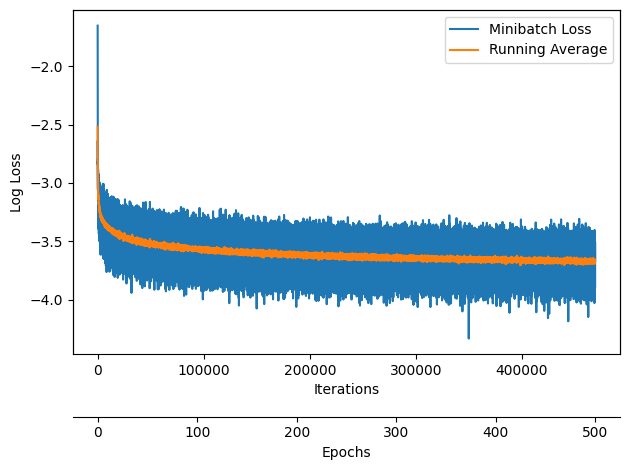

In [4]:
plot_training_loss(log_dict['train_loss_per_batch'], NUM_EPOCHS)
plt.show()

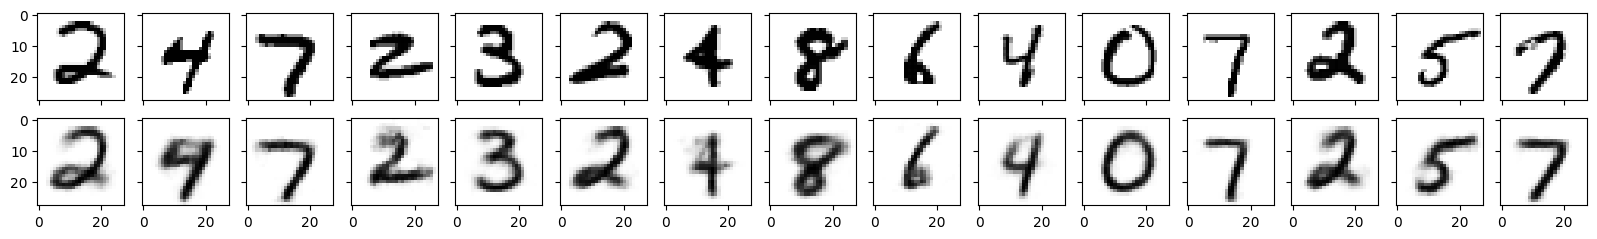

In [5]:
plot_generated_images(data_loader=train_loader, model=model, device=device)

In [6]:
torch.save(model.state_dict(), "./AE_3.pth")